In [1]:
%matplotlib inline
import numpy as np
from collections import defaultdict
import sys
import pandas as pd
import networkx as nx
import random
import matplotlib.pyplot as plt
#from gensim.models import Word2Vec
#from gensim.models.keyedvectors import KeyedVectors
#from gensim.models import Word2Vec
import pickle
from nltk.tokenize import MWETokenizer
from scipy import stats
from collections import Counter
import json
import statsmodels.api as sm
import itertools
def flushPrint(www):
 sys.stdout.write('\r')
 sys.stdout.write('%s' % www)
 sys.stdout.flush()

### 1. Collect all Youtube_data

In [2]:
import os

files = os.listdir('D:\Projects\Jupyter notebook\Youtube_data')
files

['CAvideos.csv',
 'CA_category_id.json',
 'DEvideos.csv',
 'DE_category_id.json',
 'FRvideos.csv',
 'FR_category_id.json',
 'GBvideos.csv',
 'GB_category_id.json',
 'INvideos.csv',
 'IN_category_id.json',
 'JPvideos.csv',
 'JP_category_id.json',
 'KRvideos.csv',
 'KR_category_id.json',
 'MXvideos.csv',
 'MX_category_id.json',
 'RUvideos.csv',
 'RU_category_id.json',
 'USvideos.csv',
 'US_category_id.json']

In [3]:
files_csv = [file for file in files if '.csv' in file]
files_csv

['CAvideos.csv',
 'DEvideos.csv',
 'FRvideos.csv',
 'GBvideos.csv',
 'INvideos.csv',
 'JPvideos.csv',
 'KRvideos.csv',
 'MXvideos.csv',
 'RUvideos.csv',
 'USvideos.csv']

In [4]:
import csv

region_mapping = {
    'US': 'USA',
    'GB': 'Great Britain',
    'DE': 'Germany',
    'CA': 'Canada',
    'FR': 'France',
    'RU': 'Russia',
    'MX': 'Mexico',
    'KR': 'South Korea',
    'JP': 'Japan',
    'IN': 'India'
}

path = 'D:\Projects\Jupyter notebook\Youtube_data'
youtube_videos = []

for file in files_csv:
    with open(os.path.join(path, file), 'r', encoding='iso-8859-1') as csv_file:
        csv_reader = csv.DictReader(csv_file)
        
        prefix = file[:2]
        region_name = region_mapping.get(prefix, prefix)

        for row in csv_reader:
            row['region'] = region_name
            youtube_videos.append(row)

#### Take a look of data

In [5]:
youtube_videos[0]

{'video_id': 'n1WpP7iowLc',
 'trending_date': '17.14.11',
 'title': 'Eminem - Walk On Water (Audio) ft. BeyoncÃ©',
 'channel_title': 'EminemVEVO',
 'category_id': '10',
 'publish_time': '2017-11-10T17:00:03.000Z',
 'tags': 'Eminem|"Walk"|"On"|"Water"|"Aftermath/Shady/Interscope"|"Rap"',
 'views': '17158579',
 'likes': '787425',
 'dislikes': '43420',
 'comment_count': '125882',
 'thumbnail_link': 'https://i.ytimg.com/vi/n1WpP7iowLc/default.jpg',
 'comments_disabled': 'False',
 'ratings_disabled': 'False',
 'video_error_or_removed': 'False',
 'description': "Eminem's new track Walk on Water ft. BeyoncÃ© is available everywhere: http://shady.sr/WOWEminem \\nPlaylist Best of Eminem: https://goo.gl/AquNpo\\nSubscribe for more: https://goo.gl/DxCrDV\\n\\nFor more visit: \\nhttp://eminem.com\\nhttp://facebook.com/eminem\\nhttp://twitter.com/eminem\\nhttp://instagram.com/eminem\\nhttp://eminem.tumblr.com\\nhttp://shadyrecords.com\\nhttp://facebook.com/shadyrecords\\nhttp://twitter.com/shadyrec

In [6]:
len(youtube_videos)

375942

### 2. Data Preprocessing

In [7]:
from datetime import datetime

processed_videos = []
tag_daysToTrend = {}
index = 0

for video in youtube_videos:
    # if invalid record
    if not video['tags'] or not video['trending_date'] or not video['publish_time']:
        continue

    index += 1 # the video_id have duplicates, use a index
    
    # get number of tags
    tags = video['tags'].split('|')
    tag_num = len(tags)

    # get days to trend
    trending_date = datetime.strptime(video['trending_date'], '%y.%d.%m').date()
    publish_date = datetime.strptime(video['publish_time'].split('T')[0], '%Y-%m-%d').date()
    days_to_trend = (trending_date - publish_date).days

    tag_daysToTrend[index] = [tag_num, days_to_trend]
    
    processed_videos.append(video)

youtube_videos = processed_videos

In [8]:
len(tag_daysToTrend)

375942

In [9]:
len(youtube_videos)

375942

### 3. Analyze and visualize data

In [10]:
Tag, Days = np.array(list(tag_daysToTrend.values())).T

In [11]:
max(Tag)

152

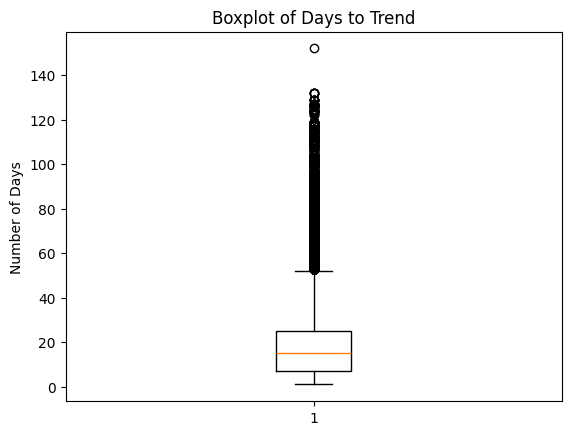

In [12]:
plt.boxplot(Tag)
plt.title("Boxplot of Days to Trend")
plt.ylabel("Number of Days")
plt.show()

In [13]:
max(Days)

4215

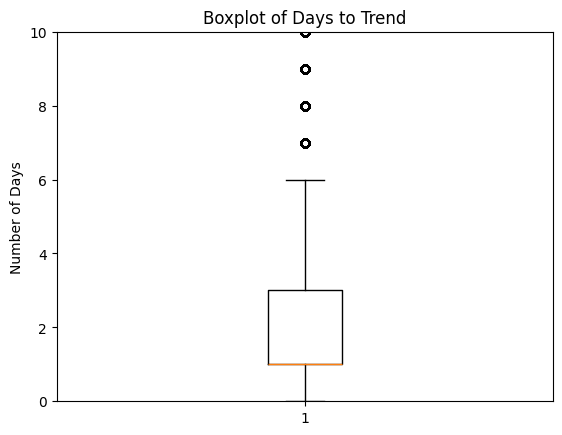

In [14]:
plt.boxplot(Days)
plt.title("Boxplot of Days to Trend")
plt.ylabel("Number of Days")

# range of y-axis
plt.ylim(0, 10)

plt.show()

In [15]:
Tag50 = [i for i in Tag if i < 50]
Days15 = [i for i in Days if i < 15]

#### Frequency of Tags

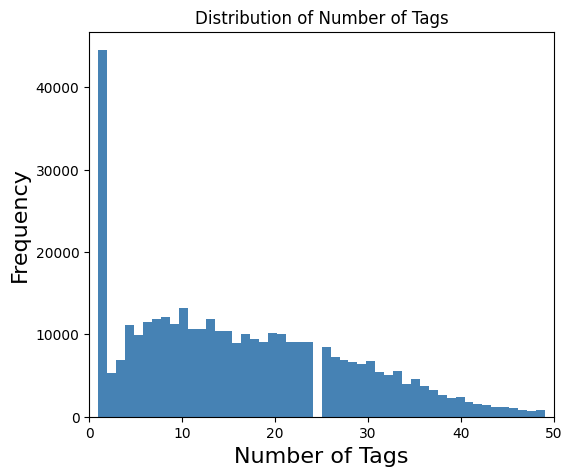

In [16]:
fig1 = plt.figure(figsize=(6, 5), facecolor='white')
plt.hist(Tag50, bins=50, color='SteelBlue')
plt.xlabel('Number of Tags', size=16)
plt.ylabel('Frequency', size=16)
plt.xlim(0, 50) 
plt.title('Distribution of Number of Tags')
plt.show()

#### Frequency of Days to trend

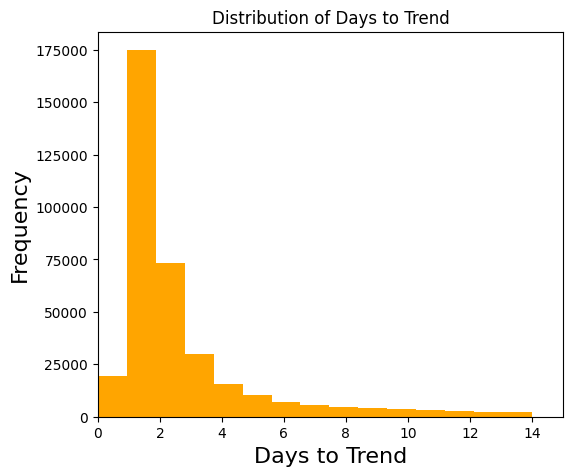

In [17]:
fig2 = plt.figure(figsize=(6, 5), facecolor='white')
plt.hist(Days15, bins=15, color='Orange') 
plt.xlabel('Days to Trend', size=16)
plt.ylabel('Frequency', size=16)
plt.xlim(0, 15)
plt.title('Distribution of Days to Trend')
plt.show()

In [18]:
def regress(x, y):
    xx = sm.add_constant(x, prepend=True)
    res = sm.OLS(y, xx).fit()
    constant, beta = res.params
    r = res.rsquared
    return constant, beta, r

In [19]:
D = defaultdict(list)

for tag, day in zip(Tag, Days):
    D[tag].append(day)

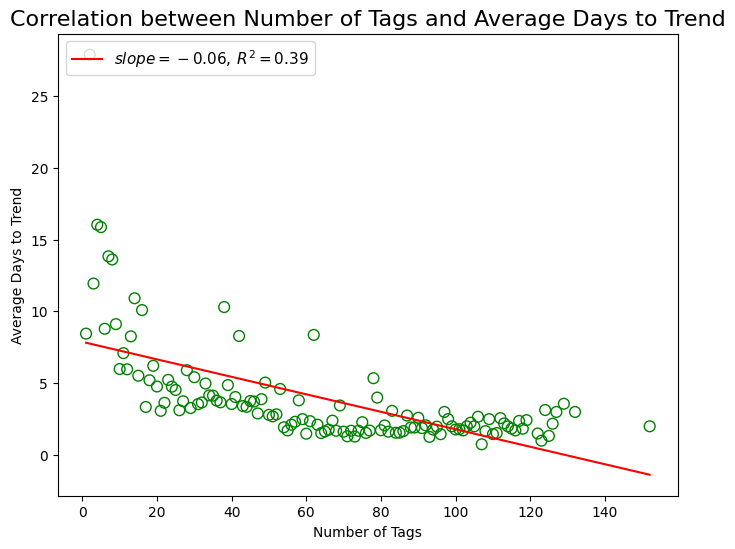

In [20]:
# average of days according to a certain number of tag
tags, mean_days = np.array([[i, np.mean(D[i])] for i in D]).T

# linear regress
constant, beta, r2 = regress(tags, mean_days)

fig = plt.figure(figsize=(8, 6))
plt.scatter(tags, mean_days, s=60, facecolors='none', edgecolors='g')
x = np.linspace(min(tags), max(tags))
lab = r'$slope = %.2f, \,R^2 = %.2f$' % (beta, r2)
plt.plot(x, constant + x*beta, "red", label=lab)
plt.legend(loc='upper left', fontsize=11)
plt.xlabel('Number of Tags', size=10)
plt.ylabel('Average Days to Trend', size=10)
plt.title('Correlation between Number of Tags and Average Days to Trend', size=16)
plt.show()

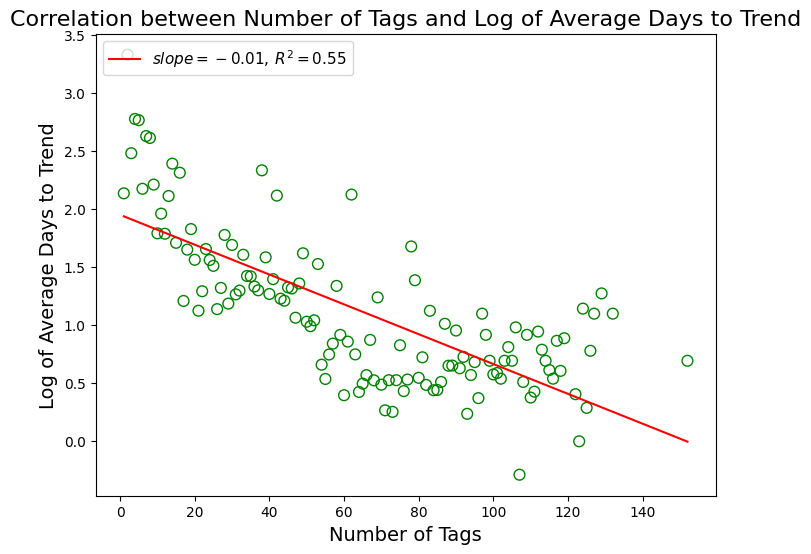

In [21]:
# log(mean_days)
tags, mean_days = np.array([[i, np.log(np.mean(D[i]))] for i in D]).T

constant, beta, r2 = regress(tags, mean_days)

fig = plt.figure(figsize=(8, 6))
plt.scatter(tags, mean_days, s=60, facecolors='none', edgecolors='g')
x = np.linspace(min(tags), max(tags))
lab = r'$slope = %.2f, \,R^2 = %.2f$' % (beta, r2)
plt.plot(x, constant + x*beta, "red", label=lab)
plt.legend(loc='upper left', fontsize=11)
plt.xlabel('Number of Tags', size=14)
plt.ylabel('Log of Average Days to Trend', size=14)
plt.title('Correlation between Number of Tags and Log of Average Days to Trend', size=16)
plt.show()

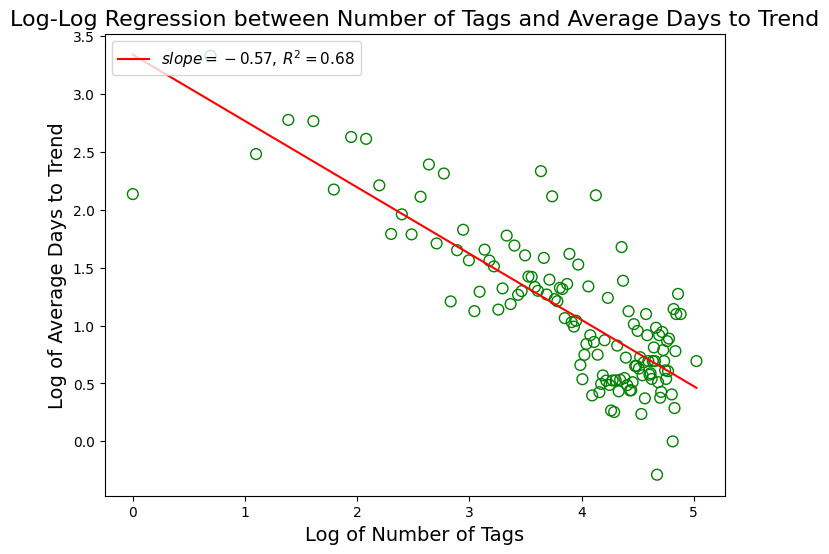

In [22]:
# log(tags), log(mean_days)
tags, mean_days = np.array([[np.log(i), np.log(np.mean(D[i]))] for i in D if i > 0]).T 

constant, beta, r2 = regress(tags, mean_days)

fig = plt.figure(figsize=(8, 6))
plt.scatter(tags, mean_days, s=60, facecolors='none', edgecolors='g')
x = np.linspace(min(tags), max(tags))
lab = r'$slope = %.2f, \,R^2 = %.2f$' % (beta, r2)
plt.plot(x, constant + x*beta, "red", label=lab)
plt.legend(loc='upper left', fontsize=11)
plt.xlabel('Log of Number of Tags', size=14)
plt.ylabel('Log of Average Days to Trend', size=14)
plt.title('Log-Log Regression between Number of Tags and Average Days to Trend', size=16)
plt.show()

### 4. Create Network

In [8]:
tag_counter = defaultdict(int)
tag_pair_counter = defaultdict(int)

for video in youtube_videos:
    tags = video['tags'].split('|')
    for tag in tags:
        tag_counter[tag] += 1
    
    for i in range(len(tags)):
        for j in range(i+1, len(tags)):
            pair = tuple(sorted([tags[i], tags[j]]))
            tag_pair_counter[pair] += 1

# top50 tags only
top_tags = [tag for tag, _ in sorted(tag_counter.items(), key=lambda x: x[1], reverse=True)[:50]]
top_tags = [tag for tag in top_tags if not any(char.isdigit() for char in tag) and tag != '[none]']
top_tags

['"funny"',
 '"comedy"',
 '"news"',
 '"music"',
 '"video"',
 '"humor"',
 '"television"',
 '"show"',
 '"review"',
 '"Pop"',
 '"vlog"',
 '"interview"',
 '"live"',
 '"food"',
 '"comedian"',
 '"funny videos"',
 '"tv"',
 '"trailer"',
 '"movie"',
 '"funny video"',
 '"how to"',
 '"Comedy"',
 '"entertainment"',
 '"rap"',
 '"celebrities"',
 '"official"',
 '"celebrity"',
 '"new"',
 '"talk show"',
 '"fun"',
 '"jokes"',
 '"hollywood"',
 '"humour"',
 '"challenge"',
 '"reaction"',
 '"film"',
 '"music video"',
 '"football"',
 '"politics"',
 '"drama"',
 '"youtube"',
 '"late night"',
 '"sketch"',
 '"sports"',
 '"Records"',
 '"highlights"',
 '"Rap"']

In [9]:
top_tags_set = set(top_tags)

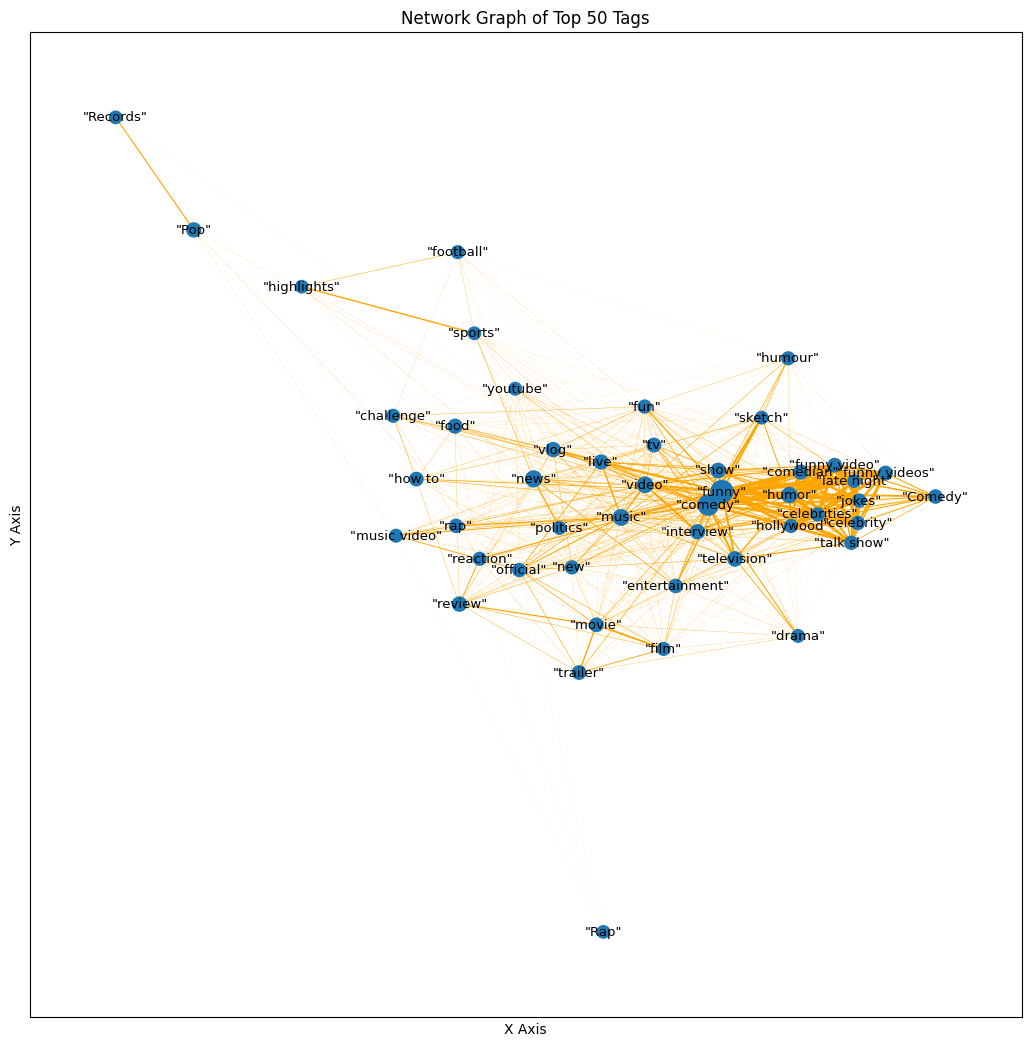

In [11]:
G = nx.Graph()

# add nodes and adjust size
max_tag_count = max(tag_counter.values())
node_sizes = [(tag_counter[tag] / max_tag_count) * 500 + 50 for tag in top_tags]

for tag in top_tags:
    G.add_node(tag)

# show weights larger than 30 only
THRESHOLD = 30

# add edges
for (tag1, tag2), weight in tag_pair_counter.items():
    if tag1 in top_tags_set and tag2 in top_tags_set and weight > THRESHOLD:
        G.add_edge(tag1, tag2, weight=weight)

# draw figure
plt.figure(figsize=(12.8, 12.8))
pos = nx.spring_layout(G, k=3.6)  # k to modify the density of graph
nx.draw_networkx_nodes(G, pos, node_size=node_sizes)
nx.draw_networkx_edges(G, pos, width=[G[u][v]['weight'] * 0.001 for u, v in G.edges()], edge_color='orange')
nx.draw_networkx_labels(G, pos, font_size=9.5)

# axis
plt.xlabel("X Axis")
plt.ylabel("Y Axis")
plt.title("Network Graph of Top 50 Tags")

plt.show()

### 5. Time series

Visualize how often the top popular tags appear over time.

In [12]:
# choose popular tags from top_tags
popular_tags = ['funny', 'news', 'music', 'television', 'show', 'review', 'Pop', 'vlog', 'interview', 'food', 'how to']

# to set
popular_tags_set = set(popular_tags)

In [13]:
tag_year_counts = defaultdict(lambda: defaultdict(int))

for video in youtube_videos:
    if not video['tags'] or not video['publish_time']:
        continue

    tags = set(video['tags'].split('|')) - {'[none]'}
    
    year = video['publish_time'][:4] 
    
    for popular_tag in popular_tags_set:
        if popular_tag in tags:
            tag_year_counts[popular_tag][year] += 1

In [14]:
tag_year_counts

defaultdict(<function __main__.<lambda>()>,
            {'news': defaultdict(int, {'2017': 44, '2018': 304}),
             'funny': defaultdict(int, {'2017': 26, '2018': 58}),
             'how to': defaultdict(int, {'2017': 56, '2018': 36}),
             'food': defaultdict(int, {'2017': 2, '2018': 51}),
             'music': defaultdict(int, {'2017': 129, '2018': 174, '2016': 2}),
             'show': defaultdict(int, {'2017': 6, '2018': 5}),
             'vlog': defaultdict(int, {'2017': 46, '2018': 25}),
             'review': defaultdict(int, {'2017': 8, '2018': 10}),
             'television': defaultdict(int, {'2018': 8}),
             'Pop': defaultdict(int, {'2018': 1, '2017': 17}),
             'interview': defaultdict(int, {'2017': 1, '2018': 1})})

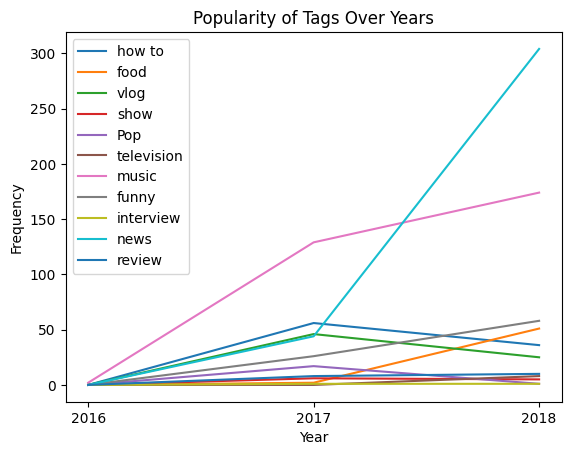

In [15]:
sorted_years = sorted(set(year for counts in tag_year_counts.values() for year in counts))

for tag in popular_tags_set:
    frequencies = [tag_year_counts[tag].get(year, 0) for year in sorted_years]
    plt.plot(sorted_years, frequencies, label=tag)

plt.legend()

plt.title('Popularity of Tags Over Years')
plt.xlabel('Year')
plt.ylabel('Frequency')

plt.show()

### 6. Text

In [16]:
year_tag_dict = defaultdict(list)

for video in youtube_videos:
    year = video['publish_time'][:4]
    
    tags = video['tags'].replace('"', '').split('|')
    for tag in tags:
        if tag != '[none]':  
            year_tag_dict[year].append(tag)

In [17]:
year_tag_dict['2016'][:5]

['New Danchall music world reggae traditional sounds jamaica dancing',
 'Rewind',
 'Rewind 2016',
 'youtube rewind 2016',
 'The Ultimate 2016 Challenge']

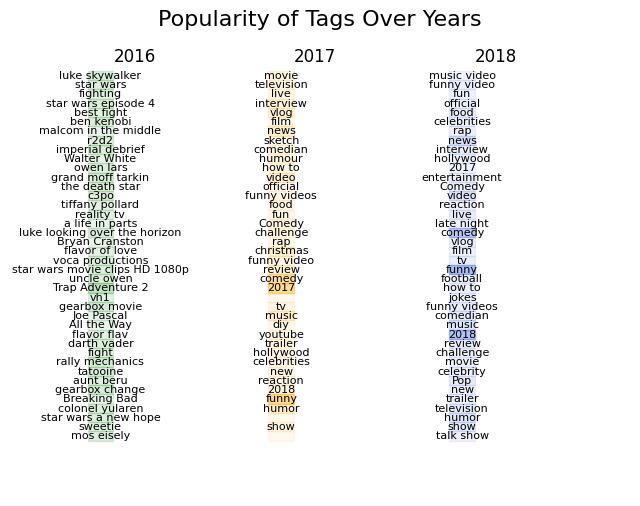

In [24]:
from matplotlib.patches import Rectangle

import random

fig = plt.figure(figsize=(8, 6))
plt.xlim(-3, 21)
plt.ylim(-45, 5)

cs = {2016: 'green', 2017: 'orange', 2018: 'royalblue'}
nBlock = 0
delta = 2

for year in [2016, 2017, 2018]:
    yearColor = cs[year]
    xdelta = (5 + delta) * nBlock
    plt.text(xdelta+1, 2, str(year), size=12)  # year
    
    tags = year_tag_dict[str(year)]
    tag_counts = Counter(tags)

    # shuffle
    top_tags = tag_counts.most_common(40)
    random.shuffle(top_tags)  
    total_count = sum(count for _, count in top_tags)
    
    rectangles = []
    for j, (keyword, count) in enumerate(top_tags):
        value = count / total_count
        x = int(j / 40) + xdelta
        y = 0 - j % 40
        alpha = min(value * 5, 1)
        rectangles.append(Rectangle((x, y), 1, 1, fill=True, color=yearColor, alpha=alpha))
        
        if value > 0.015:
            plt.text(x + 0.5, y + 0.5, keyword, size=8, ha='center', va='center', alpha=min(value ** 2 * 10000, 1))
    
    for rect in rectangles:
        plt.gca().add_patch(rect)
    
    nBlock += 1

plt.title("Popularity of Tags Over Years", size=16)
plt.axis('off')
plt.show()

### 7. Map

In [25]:
# map<region, map<tag, count>>
tag_country = {}

for video in youtube_videos:
    if not video['tags'] or not video['region']:
        continue

    tags = video['tags'].split('|')

    if video['region'] not in tag_country:
        tag_country[video['region']] = {}

    for tag in tags:
        if tag == '[none]':
            continue

        if tag not in tag_country[video['region']]:
            tag_country[video['region']][tag] = 0

        tag_country[video['region']][tag] += 1

In [26]:
top_three_usa_tags = sorted(tag_country['USA'].items(), key=lambda item: item[1], reverse=True)[:3]

for tag, count in top_three_usa_tags:
    print(f'Tag: {tag}, Frequency: {count}')

Tag: "funny", Frequency: 3584
Tag: "comedy", Frequency: 2863
Tag: "how to", Frequency: 1560


In [27]:
top_three_canada_tags = sorted(tag_country['Canada'].items(), key=lambda item: item[1], reverse=True)[:3]

for tag, count in top_three_canada_tags:
    print(f'Tag: {tag}, Frequency: {count}')

Tag: "funny", Frequency: 3383
Tag: "comedy", Frequency: 2378
Tag: "news", Frequency: 1343


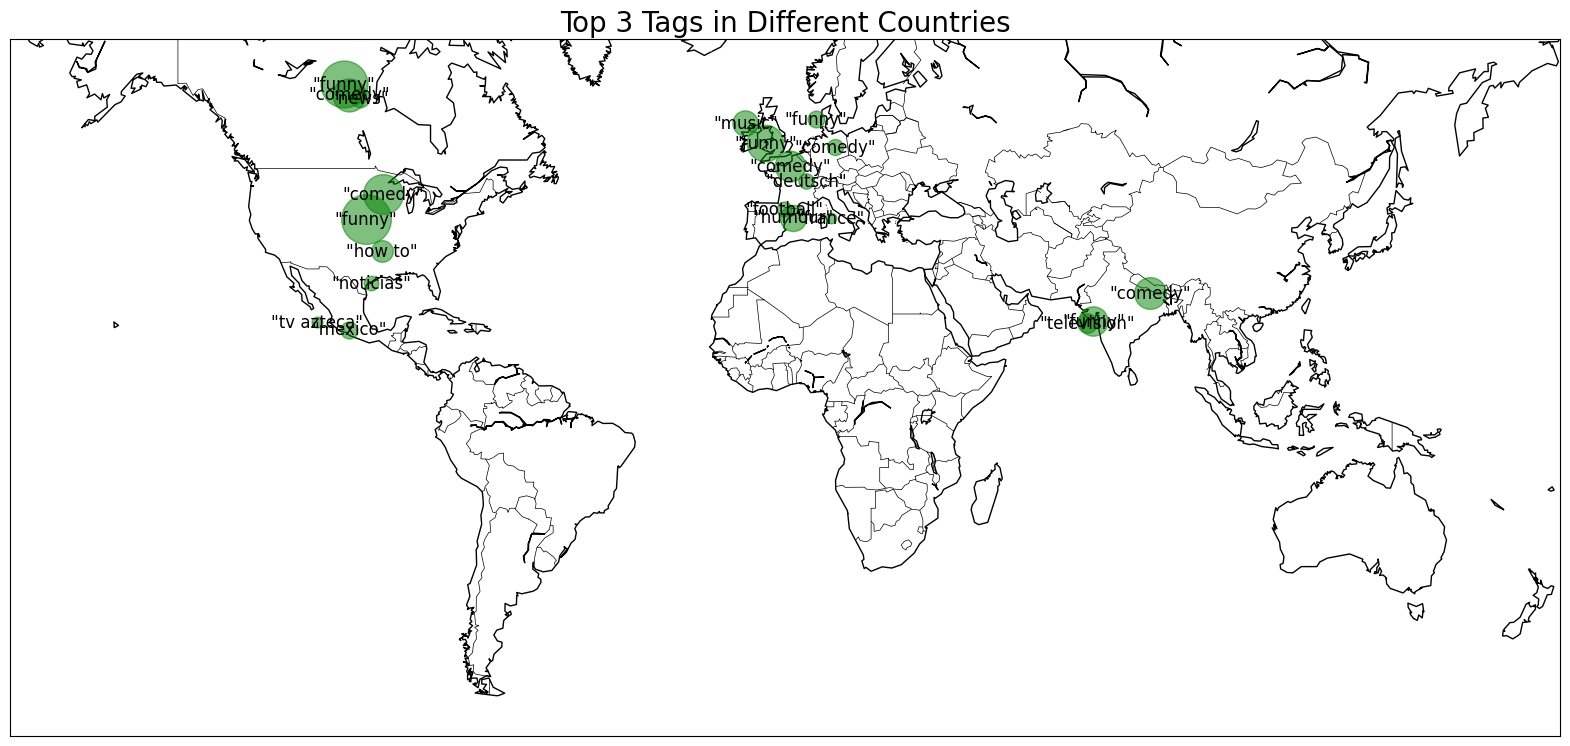

In [30]:
import matplotlib.pyplot as plt
# plt.rcParams['font.family'] = 'DejaVu Sans'
from mpl_toolkits.basemap import Basemap
import random

# world map
plt.figure(figsize=(20, 20))
plt.title('Top 3 Tags in Different Countries', fontsize=20)
m = Basemap(projection='merc', llcrnrlat=-60, urcrnrlat=65, llcrnrlon=-180, urcrnrlon=180, lat_ts=20, resolution='c')

m.drawcoastlines()
m.drawcountries()

# some countries' tags are ignored because the tags are not english
countries_coordinates = {
    'USA': (-100.445882, 39.7837304,),       
    'Great Britain': (-1.9181532, 54.3151594), 
    'Germany': (10.4478313, 51.1638175),    
    'Canada': (-107.991707, 61.0666922),   
    'France': (1.8883335, 46.603354),     
   # 'Russia': (97.7453061, 64.6863136),   
    'Mexico': (-102.0077097, 23.6585116),   
   # 'South Korea': (127.6961188, 36.638392),  
   # 'Japan': (139.2394179, 36.5748441),     
    'India': (78.6677428, 22.3511148)       
}

# top3 tags
top_tags = {}
for region, tags in tag_country.items():
    # ignore "2018"
    non_numeric_tags = {tag: count for tag, count in tags.items() if not any(char.isdigit() for char in tag)}
    
    sorted_non_numeric_tags = sorted(non_numeric_tags.items(), key=lambda item: item[1], reverse=True)
    top_tags[region] = sorted_non_numeric_tags[:3]

# randomly slightly change the center of marker
def random_displacement():
    return random.uniform(-1000000, 1000000)

# top3 tags of each country
for region, tags in top_tags.items():
    if region in countries_coordinates:
        x, y = m(*countries_coordinates[region])
        for i, (tag, count) in enumerate(tags[:3]):
            # modify the size of marker
            markersize = count * 0.01
            x_offset = random_displacement()
            y_offset = random_displacement()
            plt.plot(x + x_offset, y + y_offset, 'go', markersize=markersize, alpha=0.5) 
            plt.text(x + x_offset, y + y_offset, tag, fontsize=12, ha='center', va='center')

plt.show()